In [1]:
import pandas as pd
from datetime import datetime, timedelta
import math
import numpy as np
import warnings
from sklearn import linear_model
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
#allow me to scroll through dataframes without cutting out columns
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None 

In [2]:
#going to import my cleaned and organized data in order to create more features
#and run models I will go over the cleaning process in another article
roster = pd.read_csv('cleaned_prospect_data', sep ='|')

/Users/MattBarlowe/.virtualenvs/prospectmodel/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#create goal to total points ratios
roster['goals_to_points'] = roster['G']/roster['TP']
roster['goals_to_points'] = roster['goals_to_points'].fillna(value=0)
roster['goals_to_points'] = roster['goals_to_points'].round(decimals=2)

#create assist to total points ratios
roster['assists_to_points'] = roster['A']/roster['TP']
roster['assists_to_points'] = roster['assists_to_points'].fillna(value=0)
roster['assists_to_points'] = roster['assists_to_points'].round(decimals=2)

#calculate points per game
roster['pts_per_gp'] = roster['TP']/roster['GP']
roster['pts_per_gp'] = roster['pts_per_gp'].fillna(value = 0)
roster['pts_per_gp'] = roster['pts_per_gp'].round(decimals=2)

In [4]:
pro_leagues = [ 'Liiga', 'SHL', 'Extraliga', 'KHL' ]
tier_2_pro = ['AHL', 'Mestis','Allsvenskan']
amateur_leagues = ['NCAA', 'USHL', 'QMJHL', 'OHL', 'WHL', 'USDP']

choices = ['pro', 'pro_tier_2', 'amateur']

conditions = [(roster['league'].isin(pro_leagues)),
              (roster['league'].isin(tier_2_pro)),
              (roster['league'].isin(amateur_leagues))]

roster['league_type'] = np.select(conditions, choices)

In [5]:
NHLe_rates = {'NCAA': .369, 'KHL': .727, 'SHL': .569, 'WHL': .305, 
             'OHL': .306, 'QMJHL': .262, 'Liiga':.435, 'Extraliga': .457,
             'average': .412}

def nhl_conversion(value, rates_dict):
    return rates_dict.get(value, .421)

roster['NHLe_rates'] = roster['league'].map(NHLe_rates, na_action=.412)
roster['NHLe_tp'] = roster['TP'] * roster.NHLe_rates
roster['NHLe_ppg'] = roster.NHLe_tp/roster.GP

In [6]:
roster = pd.get_dummies(roster, columns=['league'])

In [7]:
roster.columns

Index(['Player', 'Age', 'Position', 'Birthdate', 'HT', 'WT', 'season',
       'season_start', 'draft_cutoff', 'draft_cutoff_age', 'draft_year',
       'player_id', 'GP', 'G', 'A', 'TP', 'PIM', 'playoff_GP', 'playoff_G',
       'playoff_A', 'playoff_TP', 'playoff_PIM', 'playoff_+/-',
       'goals_to_points', 'assists_to_points', 'pts_per_gp', 'nhl_GP', 'nhl_G',
       'nhl_A', 'nhl_TP', 'league_type', 'NHLe_rates', 'NHLe_tp', 'NHLe_ppg',
       'league_AHL', 'league_Allsvenskan', 'league_Extraliga', 'league_KHL',
       'league_Liiga', 'league_Mestis', 'league_NCAA', 'league_OHL',
       'league_QMJHL', 'league_SHL', 'league_USDP', 'league_USHL',
       'league_WHL'],
      dtype='object')

In [8]:
#creating df for age to points regresion stopped at 20 because the regression become negatives as younger players
#graduate to professional leagues
age_adj_score_df = roster[(roster.Age < 20) & (roster.GP >30)]

In [9]:
#splitting into defense and forwards
age_adj_def_df = age_adj_score_df[age_adj_score_df.Position == 'D']
age_adj_fwd_df = age_adj_score_df[age_adj_score_df.Position != 'D']

In [10]:
#graphing the correlation between age and points per game 
import matplotlib.pyplot as plt
ax1 = age_adj_def_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax2 = age_adj_fwd_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax1.set_title('Defense')
ax2.set_title('Forwards')
print(ax1)
print(ax2)

AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


In [11]:
#getting the coef and yint of the linear regression for points age adj.
def_adj_model = linear_model.LinearRegression()
def_adj_model.fit(age_adj_def_df[['Age']].values, age_adj_def_df['pts_per_gp'].values)
def_model_coef = round(def_adj_model.coef_[0], 3)

fwd_adj_model = linear_model.LinearRegression()
fwd_adj_model.fit(age_adj_fwd_df[['Age']].values, age_adj_fwd_df['pts_per_gp'].values)
fwd_model_coef = round(fwd_adj_model.coef_[0], 3)


/Users/MattBarlowe/.virtualenvs/prospectmodel/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [12]:
#subset main dataframe for only those players in their first draft year and split into forwards and 
#and defnse to calculate age adjusted points per game since players older than 20 will be 
#artificially enhanced by age adjusted points
draft_year_df = roster[(roster['draft_year'] == 0)]
draft_year_df_def = draft_year_df[draft_year_df.Position == 'D']
draft_year_df_fwd = draft_year_df[draft_year_df.Position != 'D']

In [13]:
#creating adjusted pts per game for forwards and defense
draft_year_df_def['age_adj_pts_g'] = (1- ((draft_year_df_def['Age']-17) * def_model_coef)) \
                                        * draft_year_df_def['pts_per_gp']
draft_year_df_fwd['age_adj_pts_g'] = (1- ((draft_year_df_fwd['Age']-17) * fwd_model_coef)) \
                                        * draft_year_df_fwd['pts_per_gp']

#(1 - ([Age as of September of draft year - 17] * 0.1672)) * Pts/GP as from Rhys Jessop formula

In [14]:
#concatting the fwds and def dataframes back together to form the old draft_year_df dataframe
frames = [draft_year_df_def, draft_year_df_fwd]
draft_year_df = pd.concat(frames)
draft_year_df = draft_year_df.fillna(value=0)

In [15]:
#Calculate NHL points per GP and fill NaN with zero for those that have zero NHL GP
draft_year_df.nhl_G = draft_year_df.nhl_G.astype('float')
draft_year_df.nhl_TP = draft_year_df.nhl_TP.astype('float')
draft_year_df.nhl_GP = draft_year_df.nhl_GP.astype('float')
draft_year_df['nhl_pts_per_gp'] = draft_year_df['nhl_TP'] / draft_year_df['nhl_GP']
draft_year_df['nhl_pts_per_gp'] = draft_year_df['nhl_pts_per_gp'].fillna(value=0)

In [16]:
#split draft_year_df into one for forwards and defensemen
draft_2018_df = draft_year_df[draft_year_df['season'] == 2018]
draft_year_df = draft_year_df[draft_year_df['season']<2018]
draft_df_fwd = draft_year_df[draft_year_df['Position'] != 'D']
draft_df_def = draft_year_df[draft_year_df['Position'] == 'D']
draft_2018_df_def = draft_2018_df[draft_2018_df['Position'] == 'D']
draft_2018_df_fwd = draft_2018_df[draft_2018_df['Position'] != 'D']

In [17]:
#Determine Forward quartile buckets for GP and pts per game
draft_df_fwd[['GP', 'nhl_pts_per_gp']].quantile([.25, .5, .75, .95, .96, .97, .98, .99])

,GP,nhl_pts_per_gp
0.25,16.0,0.000000
0.50,49.0,0.000000
0.75,62.0,0.000000
0.95,70.0,0.306876
0.96,70.0,0.360854
0.97,71.0,0.445364
0.98,72.0,0.547620
0.99,72.0,0.686364


In [18]:
#Determine Defense quartile buckets for GP and pts per game
#looks like just projecting for the 99th percentile may be the best 
#bet for both GP and points per game in order to find true NHLers
draft_df_def[['GP', 'nhl_pts_per_gp']].quantile([.25, .5, .75, .99])

,GP,nhl_pts_per_gp
0.25,16.0,0.000000
0.50,46.0,0.000000
0.75,61.0,0.000000
0.99,72.0,0.471976


In [19]:
#draft_df_def['>_39_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=40), 1, 0)
#draft_df_def['>_58_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=59), 1, 0)
draft_df_def['>_72_nhl_gp'] = np.where((draft_df_def['nhl_GP'] >=72), 1, 0)
draft_df_def['>_.25_nhl_pts_gp'] = np.where((draft_df_def['nhl_pts_per_gp'] >=.25), 1, 0)


In [20]:
draft_df_def.columns

Index(['Player', 'Age', 'Position', 'Birthdate', 'HT', 'WT', 'season',
       'season_start', 'draft_cutoff', 'draft_cutoff_age', 'draft_year',
       'player_id', 'GP', 'G', 'A', 'TP', 'PIM', 'playoff_GP', 'playoff_G',
       'playoff_A', 'playoff_TP', 'playoff_PIM', 'playoff_+/-',
       'goals_to_points', 'assists_to_points', 'pts_per_gp', 'nhl_GP', 'nhl_G',
       'nhl_A', 'nhl_TP', 'league_type', 'NHLe_rates', 'NHLe_tp', 'NHLe_ppg',
       'league_AHL', 'league_Allsvenskan', 'league_Extraliga', 'league_KHL',
       'league_Liiga', 'league_Mestis', 'league_NCAA', 'league_OHL',
       'league_QMJHL', 'league_SHL', 'league_USDP', 'league_USHL',
       'league_WHL', 'age_adj_pts_g', 'nhl_pts_per_gp', '>_72_nhl_gp',
       '>_.25_nhl_pts_gp'],
      dtype='object')

In [35]:
features = ['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 'playoff_+/-',
            'goals_to_points', 'assists_to_points', 'age_adj_pts_g', 'league_Allsvenskan', 
            'league_Extraliga','league_KHL', 'league_Liiga', 'league_Mestis', 'league_NCAA', 'league_OHL', 
            'league_QMJHL', 'league_SHL', 'league_USHL', 'league_WHL','NHLe_ppg', 'NHLe_tp']

In [36]:
#Splitting the data into 80/20 train test split with playing more than 72 games as the feature to predict 
#and greater than .25 points per game
from sklearn.model_selection import train_test_split


X_train_gp, X_test_gp, y_train_gp, y_test_gp = train_test_split(draft_df_def[features],
                                                    draft_df_def['>_72_nhl_gp'], test_size=0.2)

X_train_pts, X_test_pts, y_train_pts, y_test_pts = train_test_split(draft_df_def[features],
                                                    draft_df_def['>_.25_nhl_pts_gp'], test_size=0.2)

In [37]:
#train the logistic regression class_weight='balanced'
from sklearn.linear_model import LogisticRegression
log_reg_def_gp = LogisticRegression(class_weight='balanced')
log_reg_def_pts = LogisticRegression(class_weight='balanced')
log_reg_def_pts.fit(X_train_pts, y_train_pts)
log_reg_def_gp.fit(X_train_gp, y_train_gp)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.8523039365273115


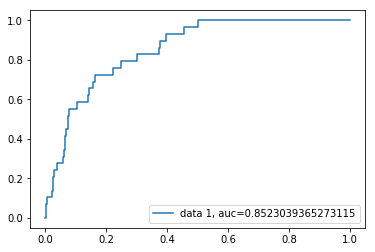

In [38]:
#calculating auc_score for plyaing more than 39 NHL games the median for Defensemen
from sklearn.metrics import roc_auc_score, roc_curve
#get probability scores for each player playing over 50 games in NHL
pred_gp_log = log_reg_def_gp.predict(X_test_gp)
y_pred_proba_log =  log_reg_def_gp.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_proba_log)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_proba_log)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.8867006336142138


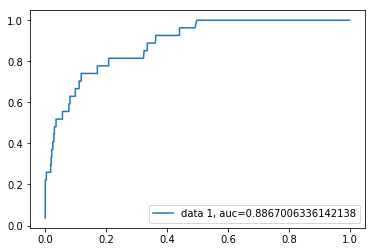

In [39]:
#calculating auc_score for plyaing more than 39 NHL games the median for Defensemen
from sklearn.metrics import roc_auc_score, roc_curve
#get probability scores for each player playing over 50 games in NHL
pred_pts_log = log_reg_def_pts.predict(X_test_pts)
y_pred_proba_log =  log_reg_def_pts.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_log)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_log)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_pts, pred_pts_log)

array([[471,  96],
       [  7,  20]])

In [41]:
from sklearn.naive_bayes import GaussianNB
gnb_gp_def = GaussianNB()
gnb_pts_def = GaussianNB()
gnb_gp_def.fit(X_train_gp, y_train_gp)
gnb_pts_def.fit(X_train_pts, y_train_pts)


GaussianNB(priors=None)

0.7584375953616113


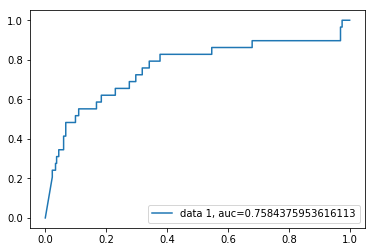

In [42]:
#naive bayes predictor
gnb_pred_gp = gnb_gp_def.predict(X_test_gp)
y_pred_prob_gnb_gp =  gnb_gp_def.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_prob_gnb_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_prob_gnb_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.855379188712522


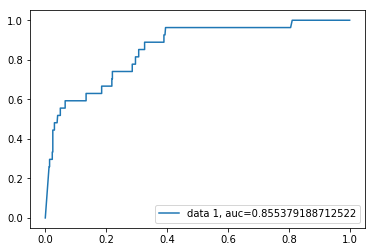

In [43]:
#naive bayes predictor
gnb_pred_pts = gnb_pts_def.predict(X_test_pts)
y_pred_prob_gnb_pts =  gnb_pts_def.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_prob_gnb_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_prob_gnb_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [44]:
from sklearn.ensemble import RandomForestClassifier as RandomForest

tree_gp_def = RandomForest(
    n_jobs= -1,
    n_estimators= 500,
     #warm_start= True, 
     #'max_features': 0.2,
    max_depth= 6,
    min_samples_leaf= 2,
    max_features = 'sqrt',
    verbose=0,
    class_weight='balanced'
)
tree_pts_def = RandomForest(
                        n_jobs= -1,
                        n_estimators= 500,
                         #warm_start= True, 
                         #'max_features': 0.2,
                        max_depth= 6,
                        min_samples_leaf= 2,
                        max_features = 'sqrt',
                        verbose=0,
                        class_weight='balanced')
tree_gp_def.fit(X_train_gp, y_train_gp)
tree_pts_def.fit(X_train_pts, y_train_pts)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=6, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

0.795971925541654


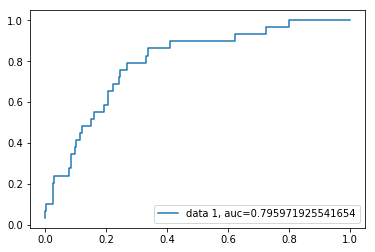

In [45]:
#random forest predictor
tree_pred_gp_def = tree_gp_def.predict(X_test_gp)
y_prob_tree_gp_def =  tree_gp_def.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_prob_tree_gp_def)
fpr, tpr, _ = roc_curve(y_test_gp,  y_prob_tree_gp_def)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.8518845123783396


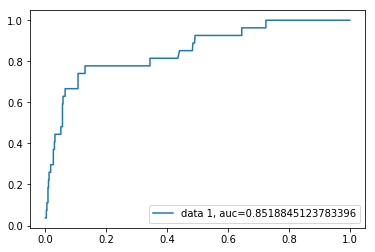

In [46]:
#random forest predictor
tree_pred_pts_def = tree_pts_def.predict(X_test_pts)
y_prob_tree_pts_def =  tree_pts_def.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_prob_tree_pts_def)
fpr, tpr, _ = roc_curve(y_test_pts,  y_prob_tree_pts_def)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [47]:
from sklearn.tree import DecisionTreeClassifier

dt_gp_def = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt_pts_def = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt_gp_def.fit(X_train_gp, y_train_gp)
dt_pts_def.fit(X_train_pts, y_train_pts)


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

0.7038754958803783


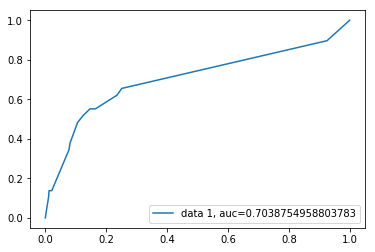

In [48]:
#Decision Tree
dt_pred_gp_def = dt_gp_def.predict(X_test_gp)
y_prob_dt_gp_def =  dt_gp_def.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_prob_dt_gp_def)
fpr, tpr, _ = roc_curve(y_test_gp,  y_prob_dt_gp_def)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.7315957933241883


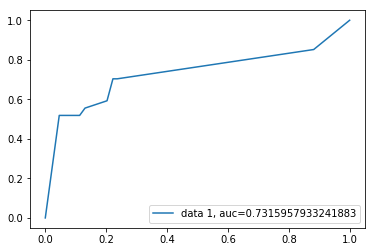

In [49]:
#Decision Tree
dt_pred_pts_def = dt_pts_def.predict(X_test_pts)
y_prob_dt_pts_def =  dt_pts_def.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_prob_dt_pts_def)
fpr, tpr, _ = roc_curve(y_test_pts,  y_prob_dt_pts_def)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [50]:
#calculate Decision Tree prediction probabilities
predictions = dt_gp_def.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt_gp_def.predict_proba(draft_2018_df_def[features])[:,1]

draft_df_def['>_72_nhl_gp_game_dt'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_dt'] = predictions_2018

In [51]:
#calculate random forest prediction probabilities
predictions = tree_gp_def.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree_gp_def.predict_proba(draft_2018_df_def[features])[:,1]

draft_df_def['>_72_nhl_gp_game_tree'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_tree'] = predictions_2018

In [52]:
#calculate random forest prediction probabilities
predictions = gnb_gp_def.predict_proba(draft_df_def[features])[::,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb_gp_def.predict_proba(draft_2018_df_def[features])[:,1]
draft_df_def['>_72_nhl_gp_game_gnb'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_gnb'] = predictions_2018

In [53]:
#calculate random forest prediction probabilities
predictions = log_reg_def_gp.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = log_reg_def_gp.predict_proba(draft_2018_df_def[features])[:,1]
draft_df_def['>_72_nhl_gp_game_log'] = predictions
draft_2018_df_def['>_72_nhl_gp_game_log'] = predictions_2018

In [54]:
#calculate Decision Tree prediction probabilities
predictions = dt_pts_def.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt_pts_def.predict_proba(draft_2018_df_def[features])[:,1]

draft_df_def['>_.42_nhl_pts_game_dt'] = predictions
draft_2018_df_def['>_.42_nhl_pts_game_dt'] = predictions_2018

In [55]:
#calculate random forest prediction probabilities
predictions = tree_pts_def.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree_pts_def.predict_proba(draft_2018_df_def[features])[:,1]

draft_df_def['>_.42_nhl_pts_game_tree'] = predictions
draft_2018_df_def['>_.42_nhl_pts_game_tree'] = predictions_2018

In [56]:
#calculate random forest prediction probabilities
predictions = gnb_pts_def.predict_proba(draft_df_def[features])[::,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb_pts_def.predict_proba(draft_2018_df_def[features])[:,1]
draft_df_def['>_.42_nhl_pts_game_gnb'] = predictions
draft_2018_df_def['>_.42_nhl_pts_game_gnb'] = predictions_2018

In [57]:
#calculate random forest prediction probabilities
predictions = log_reg_def_pts.predict_proba(draft_df_def[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = log_reg_def_pts.predict_proba(draft_2018_df_def[features])[:,1]
draft_df_def['>_.42_nhl_pts_game_log'] = predictions
draft_2018_df_def['>_.42_nhl_pts_game_log'] = predictions_2018

In [58]:
for x, y in zip(['GP', 'G', 'A', 'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP', 'playoff_+/-',
                                                                   'goals_to_points', 'assists_to_points',
                                                                    'age_adj_pts_g', 'league_Allsvenskan', 
                                                                   'league_Extraliga','league_KHL', 'league_Liiga', 
                                                                   'league_Mestis', 'league_NCAA', 'league_OHL', 
                                                                   'league_QMJHL', 'league_SHL', 
                                                                   'league_USHL', 'league_WHL','NHLe_ppg'],list(log_reg_def_pts.coef_[0])):
    print('{}: {}'.format(x,y))

GP: -0.010731139124164292
G: 0.15777005512729272
A: 0.026077281105587408
playoff_GP: 0.018603123406009857
playoff_G: 0.1001049102668299
playoff_A: 0.16701389465822528
playoff_TP: 0.03664598839156258
playoff_+/-: 1.1742908431019823
goals_to_points: 1.291295694588952
assists_to_points: 1.2056575730276373
age_adj_pts_g: -0.20492957272243786
league_Allsvenskan: 1.0204247522763894
league_Extraliga: 0.983059201950348
league_KHL: 0.12002052768739016
league_Liiga: 0.6526305246529915
league_Mestis: 0.6291995562463283
league_NCAA: -2.0651573779180294
league_OHL: -2.7306442302381657
league_QMJHL: 1.9520243138854145
league_SHL: -0.07420799530384636
league_USHL: -2.070496937247559
league_WHL: -0.42270685628613325
NHLe_ppg: 0.12424793005035102


In [59]:
draft_2018_df_def['model_average_games'] = draft_2018_df_def[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt'
]].mean(axis=1)

draft_2018_df_def['model_average_pts'] = draft_2018_df_def[['>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                                                        '>_.42_nhl_pts_game_dt', '>_.42_nhl_pts_game_tree'
]].mean(axis=1)

In [60]:
draft_2018_df_def[['Player', '>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                   '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt','model_average_games']].head(20)

,Player,>_72_nhl_gp_game_log,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_tree,>_72_nhl_gp_game_dt,model_average_games
557,Adam Boqvist,0.212901,5.541446e-17,0.091370,0.102311,0.101645
558,Adam Boqvist,0.555743,3.270393e-02,0.139911,0.793668,0.380506
752,Adam Gaudreau,0.019774,1.584373e-08,0.035741,0.102311,0.039457
768,Adam Ginning,0.783210,1.492099e-01,0.402287,0.793668,0.532094
980,Adam McCormick,0.638081,9.948220e-01,0.577670,0.687307,0.724470
1213,Adam Samuelsson,0.703938,4.279733e-04,0.508318,0.630939,0.460906
1214,Adam Samuelsson,0.500126,3.400024e-05,0.653848,0.836834,0.497710
1386,Adrien Beraldo,0.184009,2.897406e-05,0.108795,0.102311,0.098786
1423,Aidan Fulp,0.326093,1.405223e-05,0.159021,0.102311,0.146860
1435,Aidan Timmermans,0.142347,1.516411e-05,0.139310,0.102311,0.095996


In [61]:
draft_rankings_2018_def = draft_2018_df_def[['Player', 'model_average_games', 
                                         'model_average_pts']].groupby(['Player'], as_index=False).\
mean().sort_values(['model_average_pts'], ascending=False)

In [62]:
draft_rankings_2018_def = draft_rankings_2018_def.reset_index(drop=True)
draft_rankings_2018_def.index = np.arange(1,len(draft_rankings_2018_def)+1)
draft_rankings_2018_def.head(30)

,Player,model_average_games,model_average_pts
1,Quinn Hughes,0.941975,0.930232
2,Noah Dobson,0.913432,0.897862
3,Ty Smith,0.941261,0.896739
4,Nicolas Beaudin,0.935443,0.896480
5,Alexander Alexeyev,0.925422,0.888249
6,Ryan Merkley,0.921420,0.867533
7,Evan Bouchard,0.935334,0.860938
8,Rasmus Dahlin,0.907055,0.853736
9,Jared McIsaac,0.825684,0.840937
10,Jett Woo,0.764646,0.775608


In [63]:
draft_df_def['model_average_>_.25'] = draft_df_def[['>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                                                        '>_.42_nhl_pts_game_dt', '>_.42_nhl_pts_game_tree']].mean(axis=1)

draft_df_def['model_average_>_72_games']= draft_df_def[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt']].mean(axis=1)
draft_df_def = draft_df_def.sort_values(['model_average_>_.25'], ascending=False)

In [64]:
draft_rankings_def = draft_df_def[['Player', 'model_average_>_.25',
                               'model_average_>_72_games']].groupby(['Player'], as_index=False)\
.mean().sort_values(['model_average_>_.25'], ascending=False)

In [65]:
draft_rankings_def = draft_rankings_def.reset_index(drop=True)
draft_rankings_def.index = np.arange(1,len(draft_rankings_def)+1)
draft_rankings_def.head(30)

,Player,model_average_>_.25,model_average_>_72_games
1,P.K. Subban,0.965603,0.973560
2,Cody Ceci,0.963900,0.978533
3,Dougie Hamilton,0.962680,0.970686
4,Drew Doughty,0.959042,0.970615
5,Alex Pietrangelo,0.957845,0.965925
6,Michael Del Zotto,0.956684,0.972338
7,Vince Dunn,0.952867,0.972344
8,Seth Jones,0.952817,0.976413
9,Derrick Pouliot,0.951747,0.975652
10,Jakob Chychrun,0.949359,0.940642


In [67]:
#repeating process for forwards
draft_df_fwd['>_72_nhl_gp'] = np.where((draft_df_fwd['nhl_GP'] >=72), 1, 0)
draft_df_fwd['>_.42_nhl_pts_gp'] = np.where((draft_df_fwd['nhl_pts_per_gp'] >=.42), 1, 0)

X_train_gp, X_test_gp, y_train_gp, y_test_gp = train_test_split(draft_df_fwd[features],
                                                    draft_df_fwd['>_72_nhl_gp'], test_size=0.2)

X_train_pts, X_test_pts, y_train_pts, y_test_pts = train_test_split(draft_df_fwd[features],
                                                    draft_df_fwd['>_.42_nhl_pts_gp'], test_size=0.2)

In [68]:
y_test_pts.shape

(1122,)

In [69]:
#Fit log reg to both classes
logreggames = LogisticRegression(class_weight='balanced')
logregpoints = LogisticRegression(class_weight='balanced')
logreggames.fit(X_train_gp, y_train_gp)
logregpoints.fit(X_train_gp, y_train_gp)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.9011501959975242


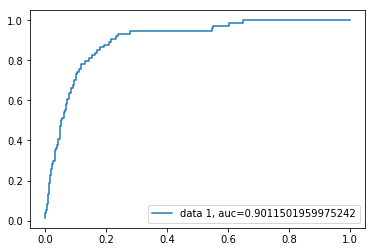

In [70]:
#get logreg probability scores for each player playing over 72 games in NHL
predict_gp = logreggames.predict(X_test_gp)
y_pred_proba_gp =  logreggames.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_proba_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_proba_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.9331036768709898


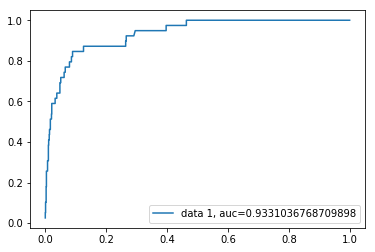

In [71]:
#get logreg probability scores for each player scoring over .42 pts per game in NHL
predict_pts = logregpoints.predict(X_test_pts)
y_pred_proba_pts =  logregpoints.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [72]:
confusion_matrix(y_test_gp, predict_gp)

array([[852, 196],
       [ 10,  64]])

In [73]:
confusion_matrix(y_test_pts, predict_pts)

array([[863, 220],
       [  5,  34]])

In [74]:
from sklearn.naive_bayes import GaussianNB
gnb_pts_fwd = GaussianNB()
gnb_gp_fwd = GaussianNB()
gnb_pts_fwd.fit(X_train_pts, y_train_pts)
gnb_gp_fwd.fit(X_train_gp, y_train_gp)
gnb_pts_pred = gnb_pts_fwd.predict(X_test_pts)
gnb_gp_pred = gnb_gp_fwd.predict(X_test_gp)


In [75]:
confusion_matrix(y_test_gp, gnb_gp_pred)

array([[914, 134],
       [ 25,  49]])

In [76]:
confusion_matrix(y_test_pts, gnb_pts_pred)

array([[969, 114],
       [ 13,  26]])

0.8520218691974418


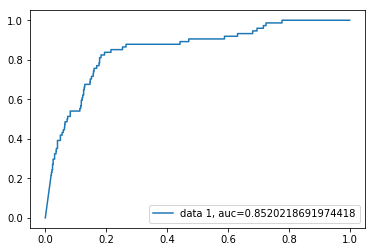

In [77]:
#get GNB probability scores for each player playing over 72 games in NHL
gnb_gp_pred = gnb_gp_fwd.predict(X_test_gp)
y_pred_proba_gp = gnb_gp_fwd.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_proba_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_proba_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.9067878873973058


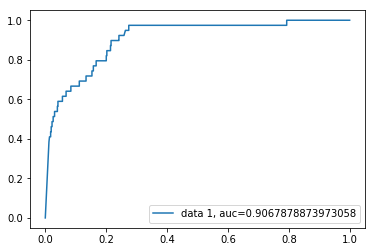

In [78]:
#get GNB probability scores for each player scoring over .42 points per games in NHL
gnb_pts_pred = gnb_pts_fwd.predict(X_test_pts)
y_pred_proba_pts = gnb_pts_fwd.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [79]:
tree_pts_fwd = RandomForest(
    n_jobs= -1,
    n_estimators= 500,
     #warm_start= True, 
     #'max_features': 0.2,
    max_depth= 6,
    min_samples_leaf= 2,
    max_features = 'sqrt',
    verbose=0,
    class_weight='balanced')

tree_gp_fwd = RandomForest(n_jobs= -1, n_estimators= 500,
                       #warm_start= True, 
                       #'max_features': 0.2,
                       max_depth= 6, min_samples_leaf= 2, max_features = 'sqrt',
                       verbose=0, class_weight='balanced')

tree_pts_fwd.fit(X_train_pts, y_train_pts)
tree_gp_fwd.fit(X_train_gp, y_train_gp)
tree_pts_pred = tree_pts_fwd.predict(X_test_pts)
tree_gp_pred = tree_gp_fwd.predict(X_test_gp)

In [80]:
confusion_matrix(y_test_gp, tree_gp_pred)

array([[924, 124],
       [ 22,  52]])

In [81]:
confusion_matrix(y_test_pts, tree_pts_pred)

array([[1023,   60],
       [  12,   27]])

0.8808541365793274


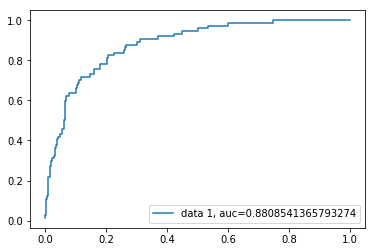

In [82]:
#get Random Forest probability scores for each forward playing over 72 games in NHL
tree_gp_pred = tree_gp_fwd.predict(X_test_gp)
y_pred_proba_gp = tree_gp_fwd.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_proba_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_proba_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.9118426971612569


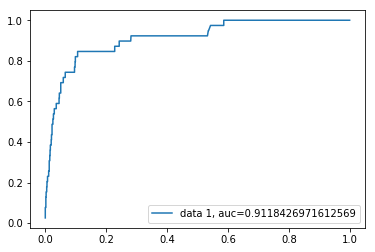

In [83]:
#get Random Forest probability scores for each forward scoring over .42 points per games in NHL
tree_pts_pred = tree_pts_fwd.predict(X_test_pts)
y_pred_proba_pts = tree_pts_fwd.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_proba_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_proba_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [84]:
from sklearn.tree import DecisionTreeClassifier

dt_pts_fwd = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt_gp_fwd = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5)
dt_pts_fwd.fit(X_train_pts, y_train_pts)
dt_gp_fwd.fit(X_train_gp, y_train_gp)
dt_pred_pts = dt_pts_fwd.predict(X_test_pts)
dt_pred_gp = dt_gp_fwd.predict(X_test_gp)


In [85]:
confusion_matrix(y_test_pts, dt_pred_pts)

array([[954, 129],
       [  9,  30]])

In [86]:
confusion_matrix(y_test_gp, dt_pred_gp)

array([[889, 159],
       [ 22,  52]])

0.8057367959562617


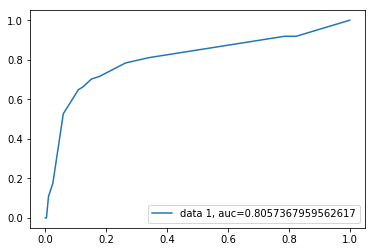

In [87]:
#Decision Tree for games played more than 72 in the NHL
dt_pred_gp = dt_gp_fwd.predict(X_test_gp)
y_pred_prob_dt_gp =  dt_gp_fwd.predict_proba(X_test_gp)[:,1]
auc = roc_auc_score(y_test_gp, y_pred_prob_dt_gp)
fpr, tpr, _ = roc_curve(y_test_gp,  y_pred_prob_dt_gp)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

0.8136231266425171


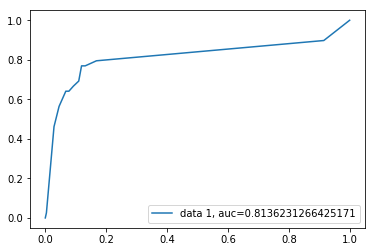

In [88]:
#Decision Tree for games played more than 72 in the NHL
dt_pred_pts = dt_pts_fwd.predict(X_test_pts)
y_pred_prob_dt_pts =  dt_pts_fwd.predict_proba(X_test_pts)[:,1]
auc = roc_auc_score(y_test_pts, y_pred_prob_dt_pts)
fpr, tpr, _ = roc_curve(y_test_pts,  y_pred_prob_dt_pts)
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [90]:
#calculate SVM prediction probabilities
predictions = dt_gp_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt_gp_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]

draft_df_fwd['>_72_nhl_gp_game_dt'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_dt'] = predictions_2018

In [91]:
#calculate random forest prediction probabilities
predictions = tree_gp_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree_gp_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]

draft_df_fwd['>_72_nhl_gp_game_tree'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_tree'] = predictions_2018




In [92]:
#calculate random forest prediction probabilities
predictions = gnb_gp_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb_gp_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]
draft_df_fwd['>_72_nhl_gp_game_gnb'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_gnb'] = predictions_2018


In [93]:
#calculate random forest prediction probabilities
predictions = logreggames.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = logreggames.predict_proba(draft_2018_df_fwd[features])[:,1]
draft_df_fwd['>_72_nhl_gp_game_log'] = predictions
draft_2018_df_fwd['>_72_nhl_gp_game_log'] = predictions_2018

In [99]:
#calculate SVM prediction probabilities
predictions = dt_pts_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = dt_pts_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]

draft_df_fwd['>_.42_nhl_pts_game_dt'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_dt'] = predictions_2018

#calculate random forest prediction probabilities
predictions = tree_pts_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = tree_pts_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]

draft_df_fwd['>_.42_nhl_pts_game_tree'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_tree'] = predictions_2018




#calculate random forest prediction probabilities
predictions = gnb_pts_fwd.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = gnb_pts_fwd.predict_proba(draft_2018_df_fwd[features])[:,1]
draft_df_fwd['>_.42_nhl_pts_game_gnb'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_gnb'] = predictions_2018


#calculate random forest prediction probabilities
predictions = logregpoints.predict_proba(draft_df_fwd[features])[:,1]
#draft_2018_df = draft_df_def[(draft_df_def['draft_year'] == 0) & (draft_df_def['season'] == 2018) & (roster['Position'] == 'D')]
predictions_2018 = logregpoints.predict_proba(draft_2018_df_fwd[features])[:,1]
draft_df_fwd['>_.42_nhl_pts_game_log'] = predictions
draft_2018_df_fwd['>_.42_nhl_pts_game_log'] = predictions_2018

In [100]:
draft_2018_df_fwd['model_average_gp'] = draft_2018_df_fwd[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt'
]].mean(axis=1)
draft_2018_df_fwd = draft_2018_df_fwd.sort_values(['model_average_gp'], ascending=False)

draft_2018_df_fwd[['Player', '>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                   '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt','model_average_gp']].head(20)

,Player,>_72_nhl_gp_game_log,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_tree,>_72_nhl_gp_game_dt,model_average_gp
6309,Andrei Svechnikov,0.991447,1.000000,0.911421,0.976536,0.969851
34049,Filip Zadina,0.942318,1.000000,0.929880,0.976536,0.962183
49861,Joel Farabee,0.955651,0.990292,0.705193,0.978205,0.907335
95458,Ryan McLeod,0.867723,1.000000,0.859446,0.880874,0.902010
1421,Aidan Dudas,0.919942,1.000000,0.803899,0.880874,0.901179
10389,Barrett Hayton,0.898828,1.000000,0.785269,0.880874,0.891243
40988,Jacob Olofsson,0.968289,0.999943,0.685507,0.880874,0.883653
17305,Cameron Hillis,0.839692,0.999878,0.803112,0.880874,0.880889
21566,Cole Fonstad,0.877228,1.000000,0.727655,0.880874,0.871439
109398,Ty Dellandrea,0.844702,0.997097,0.761663,0.880874,0.871084


In [101]:
draft_2018_df_fwd['model_average_pts'] = draft_2018_df_fwd[['>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                                                        '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt'
]].mean(axis=1)
draft_2018_df_fwd = draft_2018_df_fwd.sort_values(['model_average_pts'], ascending=False)

draft_2018_df_fwd[['Player', '>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                   '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt','model_average_pts']].head(20)

,Player,>_.42_nhl_pts_game_log,>_.42_nhl_pts_game_gnb,>_.42_nhl_pts_game_tree,>_.42_nhl_pts_game_dt,model_average_pts
6309,Andrei Svechnikov,0.991447,1.000000,0.820278,0.959402,0.942782
34049,Filip Zadina,0.942318,1.000000,0.832259,0.959402,0.933495
83824,Oliver Wahlstrom,0.988300,0.999980,0.659362,0.959402,0.901761
1421,Aidan Dudas,0.919942,0.999947,0.734710,0.922462,0.894265
1587,Akil Thomas,0.929796,1.000000,0.580806,0.959402,0.867501
10389,Barrett Hayton,0.898828,1.000000,0.621935,0.922462,0.860806
95458,Ryan McLeod,0.867723,0.999963,0.651007,0.922462,0.860289
40988,Jacob Olofsson,0.968289,0.996867,0.620160,0.854667,0.859996
5241,Allan McShane,0.832515,0.994357,0.601143,0.922462,0.837619
17305,Cameron Hillis,0.839692,0.990138,0.566363,0.922462,0.829664


In [102]:
draft_rankings_2018_fwd = draft_2018_df_fwd[['Player', 'model_average_pts',
                               'model_average_gp']].groupby(['Player'], as_index=False).mean()\
.sort_values(['model_average_pts'], ascending=False)

In [103]:
draft_rankings_2018_fwd = draft_rankings_2018_fwd.reset_index(drop=True)
draft_rankings_2018_fwd.index = np.arange(1,len(draft_rankings_2018_fwd)+1)
draft_rankings_2018_fwd.head(30)

,Player,model_average_pts,model_average_gp
1,Andrei Svechnikov,0.942782,0.969851
2,Filip Zadina,0.933495,0.962183
3,Aidan Dudas,0.894265,0.901179
4,Akil Thomas,0.867501,0.645411
5,Barrett Hayton,0.860806,0.891243
6,Ryan McLeod,0.860289,0.902010
7,Jacob Olofsson,0.859996,0.883653
8,Allan McShane,0.837619,0.867203
9,Cameron Hillis,0.829664,0.880889
10,Joseph Veleno,0.823745,0.617210


In [104]:
draft_df_fwd['model_average_pts'] = draft_df_fwd[['>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                                                        '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt'
]].mean(axis=1)
draft_df_fwd = draft_df_fwd.sort_values(['model_average_pts'], ascending=False)

draft_df_fwd[['Player', '>_.42_nhl_pts_game_log', '>_.42_nhl_pts_game_gnb', 
                   '>_.42_nhl_pts_game_tree', '>_.42_nhl_pts_game_dt','model_average_pts']].head(20)

,Player,>_.42_nhl_pts_game_log,>_.42_nhl_pts_game_gnb,>_.42_nhl_pts_game_tree,>_.42_nhl_pts_game_dt,model_average_pts
103403,Taylor Hall,0.999229,1.0,0.982682,0.959402,0.985328
52495,Jonathan Drouin,0.997947,1.0,0.980891,0.959402,0.984560
16386,Bryan Little,0.995010,1.0,0.978087,0.959402,0.983125
22476,Connor McDavid,0.999900,1.0,0.972183,0.959402,0.982871
72494,Matthew Tkachuk,0.999291,1.0,0.971652,0.959402,0.982586
2301,Alex DeBrincat,0.996675,1.0,0.968822,0.959402,0.981225
80103,Nathan MacKinnon,0.994647,1.0,0.967201,0.959402,0.980312
96524,Sam Gagner,0.998746,1.0,0.962895,0.959402,0.980260
79513,Mitchell Marner,0.998650,1.0,0.960179,0.959402,0.979558
92631,Robby Fabbri,0.997380,1.0,0.959604,0.959402,0.979096


In [105]:
draft_df_fwd['model_average_gp'] = draft_df_fwd[['>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                                                        '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt'
]].mean(axis=1)
draft_df_fwd = draft_df_fwd.sort_values(['model_average_gp'], ascending=False)

draft_df_fwd[['Player', '>_72_nhl_gp_game_log', '>_72_nhl_gp_game_gnb', 
                   '>_72_nhl_gp_game_tree', '>_72_nhl_gp_game_dt','model_average_gp']].head(20)

,Player,>_72_nhl_gp_game_log,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_tree,>_72_nhl_gp_game_dt,model_average_gp
103403,Taylor Hall,0.999229,1.0,0.977423,0.976536,0.988297
85823,Patrick Kane,0.999752,1.0,0.976742,0.976536,0.988258
52495,Jonathan Drouin,0.997947,1.0,0.977966,0.976536,0.988112
2301,Alex DeBrincat,0.996675,1.0,0.978998,0.976536,0.988052
100238,Sidney Crosby,0.999850,1.0,0.971616,0.976536,0.987000
22476,Connor McDavid,0.999900,1.0,0.970832,0.976536,0.986817
92631,Robby Fabbri,0.997380,1.0,0.972071,0.976536,0.986497
51567,John Tavares,0.998101,1.0,0.971345,0.976536,0.986495
16386,Bryan Little,0.995010,1.0,0.970757,0.976536,0.985576
46630,Jeff Skinner,0.998010,1.0,0.967291,0.976536,0.985459


In [106]:
draft_rankings_fwd = draft_df_fwd[['Player', 'season', 'model_average_pts',
                               'model_average_gp']].groupby(['Player', 'season'], as_index=False).mean()\
.sort_values(['model_average_pts'], ascending=False)

In [107]:
draft_rankings_fwd = draft_rankings_fwd.reset_index(drop=True)
draft_rankings_fwd.index = np.arange(1,len(draft_rankings_fwd)+1)
draft_rankings_2017 = draft_rankings_fwd[draft_rankings_fwd['season']==2017].head(30)
draft_rankings_2017 = draft_rankings_2017.reset_index(drop=True)
draft_rankings_2017.index = np.arange(1,len(draft_rankings_2017)+1)

In [112]:
draft_rankings_fwd[draft_rankings_fwd['season'] == 2013]

,Player,season,model_average_pts,model_average_gp
2,Jonathan Drouin,2013,0.984560,0.988112
7,Nathan MacKinnon,2013,0.980312,0.983318
25,Max Domi,2013,0.973029,0.981615
55,Hunter Shinkaruk,2013,0.951646,0.955698
56,Sean Monahan,2013,0.951029,0.958149
80,Anthony Mantha,2013,0.938839,0.931414
82,Aleksander Barkov,2013,0.937373,0.959824
93,Kerby Rychel,2013,0.931195,0.944351
105,Bo Horvat,2013,0.926569,0.917071
123,Nic Petan,2013,0.913890,0.979924


In [219]:
draft_2018_df_fwd.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,goals_to_points,assists_to_points,pts_per_gp,nhl_GP,nhl_G,nhl_A,nhl_TP,age_adj_pts_g,nhl_pts_per_gp,league_Allsvenskan,league_Extraliga,league_KHL,league_Liiga,league_Mestis,league_NCAA,league_OHL,league_QMJHL,league_SHL,league_USDP,league_USHL,league_WHL,>_72_nhl_gp_game_dt,>_72_nhl_gp_game_tree,>_.42_nhl_pts_game_dt,>_.42_nhl_pts_game_tree,>_72_nhl_gp_game_gnb,>_72_nhl_gp_game_log,>_.42_nhl_pts_game_gnb,>_.42_nhl_pts_game_log,model_average,model_average_gp,model_average_pts
87647,14,Andrei Svechnikov,17.47,RW,2000-03-26,"Barnaul, RUS",6.25,187,L,328556,865,2018,Barrie Colts,2017-09-15,2018-09-15,18.472,0,44,40,32,72,67,8,5,6,11,12,-1,0.56,0.44,1.64,0.0,0.0,0,0.0,1.567545,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0.942813,0.888051,0.967336,0.779691,1.000000,0.988396,1.000000,0.988397,0.954815,0.954815,0.933856
103286,18,Oliver Wahlstrom,17.26,C/RW,2000-06-13,"Yarmouth, ME, USA",6.08,205,R,241370,1864,2018,U.S. National U18 Team,2017-09-15,2018-09-15,18.256,0,62,48,46,94,42,0,0,0,0,0,0,0.51,0.49,1.52,0.0,0.0,0,0.0,1.482851,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0.942813,0.825256,0.967336,0.786628,1.000000,0.997271,0.999995,0.997271,0.941335,0.941335,0.937807
96834,11,Filip Zadina,17.80,LW,1999-11-27,"Pardubice, CZE",6.08,192,L,236471,885,2018,Halifax Mooseheads,2017-09-15,2018-09-15,18.801,0,57,44,38,82,36,9,5,7,12,0,2,0.54,0.46,1.44,0.0,0.0,0,0.0,1.331712,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0.942813,0.890255,0.967336,0.878163,1.000000,0.928457,1.000000,0.928458,0.940381,0.940381,0.943489
103269,28,Joel Farabee,17.56,LW,2000-02-25,"Cicero, NY, USA",6,168,L,334036,1864,2018,U.S. National U18 Team,2017-09-15,2018-09-15,18.554,0,62,33,43,76,44,0,0,0,0,0,0,0.43,0.57,1.23,0.0,0.0,0,0.0,1.165253,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0.942813,0.829568,0.967336,0.830511,0.999943,0.986693,0.880039,0.986693,0.939754,0.939754,0.916145
110221,18,Jack Drury,17.62,C,2000-02-03,"Winnetka, IL, USA",5.92,179,L,283916,907,2018,Waterloo Black Hawks,2017-09-15,2018-09-15,18.615,0,56,24,41,65,83,6,3,1,4,2,2,0.37,0.63,1.16,0.0,0.0,0,0.0,1.092395,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0.942813,0.838905,0.967336,0.633906,0.999597,0.928022,0.480779,0.928022,0.927334,0.927334,0.752511


In [169]:
draft_rankings = draft_df_fwd[['Player', 'season','model_average_pts',
                               'model_average_gp']].\
groupby(['Player', 'season'], as_index=False).mean().sort_values(['model_average_pts'], ascending=False)

KeyError: "['model_average_pts' 'model_average_gp'] not in index"

In [280]:
draft_rankings_fwd = draft_rankings.reset_index(drop=True)
draft_rankings_fwd.index = np.arange(1,len(draft_rankings_fwd)+1)
draft_rankings_fwd.head(30)

NameError: name 'draft_rankings' is not defined